In [1]:
import os
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

In [2]:
### READ DATASET ###

df = pd.read_csv('avocado.csv', index_col=0, parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df['test_flag'] = (df['year']==2018)

print(df.shape)
df.head()

(18249, 13)


,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,test_flag
Date,,,,,,,,,,,,,
2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast,False
2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago,False
2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton,False
2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh,False
2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise,False


In [3]:
### PLOT SERIES FOR SINGLE MARKET OF SELECTED AVOCADO TYPE ###

def plot_seris(county, typ):
    
    plt.figure(figsize=(9,6))
    
    df[(df['type']==typ)&(df['region']==county)&(df['test_flag']==False)]['AveragePrice'].plot()
    df[(df['type']==typ)&(df['region']==county)&(df['test_flag']==True)]['AveragePrice'].plot()
    
    plt.title('AveragePrice'+' '+typ.upper()+' '+county)
    plt.show()

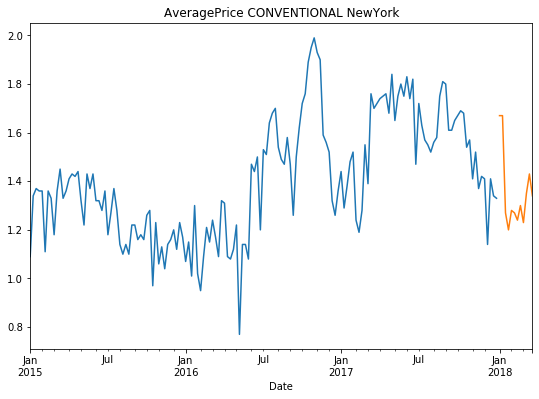

In [4]:
reg_train = plot_seris('NewYork','conventional')

In [5]:
### CREATE GENERATOR FOR LSTM WINDOWS AND LABELS ###

sequence_length = 4


def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [6]:
### CREATE TRAIN/TEST PRICE DATA ###

col = ['AveragePrice','Total Volume','4046','4225','4770','Total Bags','Small Bags','Large Bags','XLarge Bags']

X_train, X_test = [], []
y_train, y_test = [], []

for (county,typ,is_test), _df in df.groupby(["region", "type", "test_flag"]):
    
    for seq in gen_sequence(_df, sequence_length, col):            
        
        if is_test:
            X_test.append(seq)
        else:
            X_train.append(seq)

        if is_test:
            X_test.append(seq)
        else:
            X_train.append(seq)
                
    for seq in gen_labels(_df, sequence_length, ['AveragePrice']):
        
        if is_test:
            y_test.append(seq)
        else:
            y_train.append(seq)

        if is_test:
            y_test.append(seq)
        else:
            y_train.append(seq)      
        
        
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33042, 4, 9) (33042, 1)
(1728, 4, 9) (1728, 1)


In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

# FORECASTER + AUTOENCODER

In [8]:
set_seed(33)

### DEFINE LSTM AUTOENCODER ###

inputs_ae = Input(shape=(X_train.shape[1:]))
encoded_ae = LSTM(128, return_sequences=True, dropout=0.5)(inputs_ae, training=True)
decoded_ae = LSTM(32, return_sequences=True, dropout=0.5)(encoded_ae, training=True)
out_ae = TimeDistributed(Dense(1))(decoded_ae)

sequence_autoencoder = Model(inputs_ae, out_ae)
sequence_autoencoder.compile(optimizer='adam', loss='mse')

### TRAIN AUTOENCODER ###
es = EarlyStopping(patience=6, verbose=2, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
sequence_autoencoder.fit(X_train, X_train, validation_data=(X_train, X_train),
                         batch_size=128, epochs=100, verbose=1, callbacks=[es])

Epoch 1/100
259/259 [==============================] - 4s 14ms/step - loss: 0.4868 - val_loss: 0.4005
Epoch 2/100
259/259 [==============================] - 3s 12ms/step - loss: 0.3867 - val_loss: 0.3809
Epoch 3/100
259/259 [==============================] - 3s 12ms/step - loss: 0.3761 - val_loss: 0.3714
Epoch 4/100
259/259 [==============================] - 3s 12ms/step - loss: 0.3726 - val_loss: 0.3717
Epoch 5/100
259/259 [==============================] - 3s 12ms/step - loss: 0.3718 - val_loss: 0.3696
Epoch 6/100
259/259 [==============================] - 4s 14ms/step - loss: 0.3679 - val_loss: 0.3647
Epoch 7/100
259/259 [==============================] - 3s 12ms/step - loss: 0.3641 - val_loss: 0.3657
Epoch 8/100
259/259 [==============================] - 3s 12ms/step - loss: 0.3648 - val_loss: 0.3616
Epoch 9/100
259/259 [==============================] - 3s 12ms/step - loss: 0.3631 - val_loss: 0.3637
Epoch 10/100
259/259 [==============================] - 3s 13ms/step - loss: 0.363

In [9]:
### ENCODE PRICE AND CONCATENATE REGRESSORS ###

encoder = Model(inputs_ae, encoded_ae)
X_train_ = np.concatenate([X_train, encoder.predict(X_train)], axis=-1)
X_test_ = np.concatenate([X_test, encoder.predict(X_test)], axis=-1)

X_train_.shape, X_test_.shape

((33042, 4, 137), (1728, 4, 137))

In [10]:
set_seed(33)

### DEFINE FORECASTER ###

inputs = Input(shape=(X_train_.shape[1:]))
lstm = LSTM(128, return_sequences=True, dropout=0.5)(inputs, training=True)
lstm = LSTM(32, return_sequences=False, dropout=0.5)(lstm, training=True)
dense = Dense(50)(lstm)
out = Dense(1)(dense)

model = Model(inputs, out)
model.compile(loss='mse', optimizer='adam')

### FIT FORECASTER ###
es = EarlyStopping(patience=6, verbose=2, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
model.fit(X_train_, y_train, validation_data=(X_train_, y_train), 
          epochs=100, batch_size=128, verbose=1, callbacks=[es])

Epoch 1/100
259/259 [==============================] - 5s 17ms/step - loss: 0.1181 - val_loss: 0.0489
Epoch 2/100
259/259 [==============================] - 4s 15ms/step - loss: 0.0475 - val_loss: 0.0457
Epoch 3/100
259/259 [==============================] - 4s 15ms/step - loss: 0.0444 - val_loss: 0.0432
Epoch 4/100
259/259 [==============================] - 4s 15ms/step - loss: 0.0427 - val_loss: 0.0413
Epoch 5/100
259/259 [==============================] - 4s 16ms/step - loss: 0.0418 - val_loss: 0.0404
Epoch 6/100
259/259 [==============================] - 4s 15ms/step - loss: 0.0406 - val_loss: 0.0408
Epoch 7/100
259/259 [==============================] - 4s 15ms/step - loss: 0.0400 - val_loss: 0.0393
Epoch 8/100
259/259 [==============================] - 4s 15ms/step - loss: 0.0392 - val_loss: 0.0388
Epoch 9/100
259/259 [==============================] - 4s 15ms/step - loss: 0.0385 - val_loss: 0.0381
Epoch 10/100
259/259 [==============================] - 4s 15ms/step - loss: 0.038

In [11]:
### COMPUTE STOCHASTIC DROPOUT ###

scores = []
for i in tqdm.tqdm(range(0,100)):
    scores.append(mean_absolute_error(y_test, model.predict(X_test_).ravel()))

print(np.mean(scores), np.std(scores))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.08it/s]

0.12049458980871436 0.0013504556151708717


In [12]:
results = {'LSTM':None, 'AE+LSTM':None}
results['AE+LSTM'] = {'mean':np.mean(scores), 'std':np.std(scores)}

# SIMPLE FORECASTER

In [13]:
set_seed(33)

### DEFINE FORECASTER ###

inputs = Input(shape=(X_train.shape[1:]))
lstm = LSTM(128, return_sequences=True, dropout=0.5)(inputs, training=True)
lstm = LSTM(32, return_sequences=False, dropout=0.5)(lstm, training=True)
dense = Dense(50)(lstm)
out = Dense(1)(dense)

model = Model(inputs, out)
model.compile(loss='mse', optimizer='adam')

### FIT FORECASTER ###
es = EarlyStopping(patience=6, verbose=2, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_train, y_train), 
          epochs=100, batch_size=128, verbose=1, callbacks=[es])

Epoch 1/100
259/259 [==============================] - 4s 15ms/step - loss: 0.1734 - val_loss: 0.0569
Epoch 2/100
259/259 [==============================] - 3s 13ms/step - loss: 0.0558 - val_loss: 0.0556
Epoch 3/100
259/259 [==============================] - 3s 13ms/step - loss: 0.0527 - val_loss: 0.0502
Epoch 4/100
259/259 [==============================] - 3s 12ms/step - loss: 0.0511 - val_loss: 0.0497
Epoch 5/100
259/259 [==============================] - 3s 12ms/step - loss: 0.0497 - val_loss: 0.0481
Epoch 6/100
259/259 [==============================] - 3s 12ms/step - loss: 0.0483 - val_loss: 0.0478
Epoch 7/100
259/259 [==============================] - 3s 12ms/step - loss: 0.0475 - val_loss: 0.0470
Epoch 8/100
259/259 [==============================] - 3s 12ms/step - loss: 0.0469 - val_loss: 0.0463
Epoch 9/100
259/259 [==============================] - 3s 13ms/step - loss: 0.0464 - val_loss: 0.0458
Epoch 10/100
259/259 [==============================] - 3s 13ms/step - loss: 0.045

In [14]:
### COMPUTE STOCHASTIC DROPOUT ###

scores = []
for i in tqdm.tqdm(range(0,100)):
    scores.append(mean_absolute_error(y_test, model.predict(X_test).ravel()))

print(np.mean(scores), np.std(scores))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.67it/s]

0.12859090614447166 0.0017708181930074153


In [15]:
results['LSTM'] = {'mean':np.mean(scores), 'std':np.std(scores)}

(None, None)

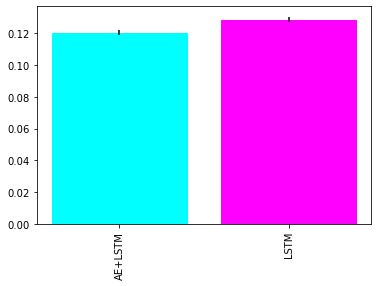

In [16]:
### PLOT AVG AND UNCERTAINTY OF RESULTS ###

bar = plt.bar([0,1], [results['AE+LSTM']['mean'], results['LSTM']['mean']], 
              yerr=[results['AE+LSTM']['std'], results['LSTM']['std']])
plt.xticks([0,1], ['AE+LSTM','LSTM'], rotation=90)
bar[0].set_color('cyan'), bar[1].set_color('magenta')